# Code for analyzing average AUC of swimmers in each of our sinks 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Union
import numpy as np
import pandas as pd

# Helpers to compute proportions per sink in physical space
SinkSpec = Union[Dict[str, float], Tuple[float, float, float, float], Tuple[float, float, float, float, float, float]]


def _normalize_sinks(sinks: Union[SinkSpec, List[SinkSpec]]) -> List[Dict[str, float]]:
	"""Coerce sinks into a uniform list of dicts with bounds and a name."""
	if isinstance(sinks, (dict, tuple, list)):
		sinks = [sinks] if not isinstance(sinks, list) else sinks
	else:
		raise ValueError("'sinks' must be a dict, tuple/list, or a list of those")

	normalized = []
	for i, s in enumerate(sinks):
		if isinstance(s, dict):
			name = s.get('name', f'sink_{i}')
			xmin = s.get('ixmin', s.get('xmin', -np.inf))
			xmax = s.get('ixmax', s.get('xmax',  np.inf))
			ymin = s.get('iymin', s.get('ymin', -np.inf))
			ymax = s.get('iymax', s.get('ymax',  np.inf))
			zmin = s.get('izmin', s.get('zmin', -np.inf))
			zmax = s.get('izmax', s.get('zmax',  np.inf))
		elif isinstance(s, (tuple, list)) and len(s) in (4, 6):
			name = f'sink_{i}'
			if len(s) == 4:
				xmin, xmax, ymin, ymax = s
				zmin, zmax = -np.inf, np.inf
			else:
				xmin, xmax, ymin, ymax, zmin, zmax = s
		else:
			raise ValueError("Each sink must be a dict with *min/*max keys or a 4/6-tuple of bounds")

		normalized.append({
			'name': name,
			'xmin': float(xmin), 'xmax': float(xmax),
			'ymin': float(ymin), 'ymax': float(ymax),
			'zmin': float(zmin), 'zmax': float(zmax),
		})
	return normalized


def compute_sink_proportions(positions: np.ndarray, sinks: Union[SinkSpec, List[SinkSpec]]):
	"""Return (proportions[S, T], names[S]) where proportions[s, t] is the fraction of swimmers in sink s at time t."""
	if not isinstance(positions, np.ndarray) or positions.ndim != 3:
		raise ValueError("positions must be a np.ndarray of shape (T, N, D)")
	T, N, D = positions.shape
	if D < 2:
		raise ValueError("positions must have at least 2 spatial dimensions (x,y)")

	norm_sinks = _normalize_sinks(sinks)
	S = len(norm_sinks)
	proportions = np.zeros((S, T), dtype=float)

	for t in range(T):
		x = positions[t, :, 0]
		y = positions[t, :, 1]
		z = positions[t, :, 2] if D >= 3 else 0.0
		for s_idx, s in enumerate(norm_sinks):
			mask = (
				(x >= s['xmin']) & (x <= s['xmax']) &
				(y >= s['ymin']) & (y <= s['ymax']) &
				((z >= s['zmin']) & (z <= s['zmax']) if D >= 3 else True)
			)
			proportions[s_idx, t] = float(np.count_nonzero(mask)) / float(N)

	names = [s['name'] for s in norm_sinks]
	return proportions, names


def plot_sink_proportions_combined(proportions: np.ndarray, names: List[str], dt: float = 1.0, title: str = None):
	T = proportions.shape[1]
	t = np.arange(T) * float(dt)
	plt.figure(figsize=(9, 4))
	for i, name in enumerate(names):
		plt.plot(t, proportions[i], label=name, linewidth=2)
	plt.ylim(0.0, 1.0)
	plt.xlabel('time')
	plt.ylabel('proportion in sink')
	plt.grid(alpha=0.3)
	plt.legend()
	if title:
		plt.title(title)
	plt.tight_layout()
	plt.show()


def plot_sink_proportions_separate(proportions: np.ndarray, names: List[str], dt: float = 1.0, cols: int = 2, title: str = None):
	S, T = proportions.shape
	t = np.arange(T) * float(dt)
	rows = int(np.ceil(S / float(cols))) if S > 0 else 1
	fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, max(1, rows) * 3), sharex=True, sharey=True)
	axes = np.atleast_1d(axes).ravel()
	for i in range(S):
		ax = axes[i]
		ax.plot(t, proportions[i], linewidth=2)
		ax.set_title(names[i])
		ax.set_ylim(0.0, 1.0)
		ax.grid(alpha=0.3)
	for j in range(S, len(axes)):
		axes[j].axis('off')
	fig.supxlabel('time')
	fig.supylabel('proportion in sink')
	if title:
		fig.suptitle(title)
	fig.tight_layout()
	plt.show()


IndexSinkSpec = Union[Dict[str, int], Tuple[int, int, int, int], Tuple[int, int, int, int, int, int]]


def positions_to_grid_indices(positions: np.ndarray,
							   Lx: float, Ly: float, Lz: float,
							   Nx: int, Ny: int, Nz: int) -> np.ndarray:
	"""Map physical positions (m) to grid indices using floor(x/L*Nr) and clipping.
	positions shape: (T, N, 3)
	Returns int64 array of shape (T, N, 3) with columns [ix, iy, iz]."""
	if positions.ndim != 3 or positions.shape[2] < 3:
		raise ValueError("positions must be (T, N, 3)")
	T, N, _ = positions.shape
	ix = np.floor(positions[:, :, 0] / float(Lx) * int(Nx)).astype(np.int64)
	iy = np.floor(positions[:, :, 1] / float(Ly) * int(Ny)).astype(np.int64)
	iz = np.floor(positions[:, :, 2] / float(Lz) * int(Nz)).astype(np.int64)
	ix = np.clip(ix, 0, int(Nx) - 1)
	iy = np.clip(iy, 0, int(Ny) - 1)
	iz = np.clip(iz, 0, int(Nz) - 1)
	idx = np.empty((T, N, 3), dtype=np.int64)
	idx[:, :, 0] = ix
	idx[:, :, 1] = iy
	idx[:, :, 2] = iz
	return idx


def _normalize_index_sinks(sinks: Union[IndexSinkSpec, List[IndexSinkSpec]],
						   Ny: int, Nx: int, Nz: int) -> List[Dict[str, int]]:
	"""Coerce sinks into a uniform list of dicts with integer index bounds and a name.
	If some bounds are omitted, they default to the full range for that axis."""
	if isinstance(sinks, (dict, tuple, list)):
		sinks = [sinks] if not isinstance(sinks, list) else sinks
	else:
		raise ValueError("'sinks' must be a dict, tuple/list, or a list of those")

	norm = []
	for i, s in enumerate(sinks):
		if isinstance(s, dict):
			name = s.get('name', f'sink_{i}')
			ixmin = s.get('ixmin', 0)
			ixmax = s.get('ixmax', Nx - 1)
			iymin = s.get('iymin', 0)
			iymax = s.get('iymax', Ny - 1)
			izmin = s.get('izmin', 0)
			izmax = s.get('izmax', Nz - 1)
		elif isinstance(s, (tuple, list)) and len(s) in (4, 6):
			name = f'sink_{i}'
			if len(s) == 4:
				ixmin, ixmax, iymin, iymax = s
				izmin, izmax = 0, Nz - 1
			else:
				ixmin, ixmax, iymin, iymax, izmin, izmax = s
		else:
			raise ValueError("Each sink must be a dict with ix*/iy*/iz* keys or a 4/6-tuple of index bounds")

		# coerce to ints and clip within grid
		entry = {
			'name': name,
			'ixmin': int(max(0, min(ixmin, Nx - 1))),
			'ixmax': int(max(0, min(ixmax, Nx - 1))),
			'iymin': int(max(0, min(iymin, Ny - 1))),
			'iymax': int(max(0, min(iymax, Ny - 1))),
			'izmin': int(max(0, min(izmin, Nz - 1))),
			'izmax': int(max(0, min(izmax, Nz - 1))),
		}
		# ensure min<=max
		if entry['ixmin'] > entry['ixmax'] or entry['iymin'] > entry['iymax'] or entry['izmin'] > entry['izmax']:
			raise ValueError(f"Invalid bounds for {name}: mins must be <= maxes")
		norm.append(entry)
	return norm


def compute_sink_proportions_from_index_bounds(
	positions: np.ndarray,
	sinks: Union[IndexSinkSpec, List[IndexSinkSpec]],
	Lx: float, Ly: float, Lz: float,
	Nx: int, Ny: int, Nz: int,
):
	"""Compute per-sink proportions over time, with sinks defined in GRID INDEX space.

	positions: (T, N, 3) in meters
	sinks: dicts/tuples with ix/iy/iz min/max bounds
	L*, N*: box lengths (m) and grid resolution along each axis
	Returns: proportions (S, T), names (S)
	"""
	if not isinstance(positions, np.ndarray) or positions.ndim != 3:
		raise ValueError("positions must be (T, N, 3)")
	T, N, _ = positions.shape

	idx = positions_to_grid_indices(positions, Lx, Ly, Lz, Nx, Ny, Nz)
	norm_sinks = _normalize_index_sinks(sinks, Ny=Ny, Nx=Nx, Nz=Nz)
	S = len(norm_sinks)
	proportions = np.zeros((S, T), dtype=float)

	for t in range(T):
		ix_t = idx[t, :, 0]
		iy_t = idx[t, :, 1]
		iz_t = idx[t, :, 2]
		for s_idx, s in enumerate(norm_sinks):
			mask = (
				(ix_t >= s['ixmin']) & (ix_t <= s['ixmax']) &
				(iy_t >= s['iymin']) & (iy_t <= s['iymax']) &
				(iz_t >= s['izmin']) & (iz_t <= s['izmax'])
			)
			proportions[s_idx, t] = float(np.count_nonzero(mask)) / float(N)

	names = [s['name'] for s in norm_sinks]
	return proportions, names


# Grid-index based helpers for proportions
IndexSinkSpec = Union[Dict[str, int], Tuple[int, int, int, int], Tuple[int, int, int, int, int, int]]


def positions_to_grid_indices(positions: np.ndarray,
							   Lx: float, Ly: float, Lz: float,
							   Nx: int, Ny: int, Nz: int) -> np.ndarray:
	"""Map physical positions (m) to grid indices using floor(x/L*Nr) and clipping."""
	if positions.ndim != 3 or positions.shape[2] < 3:
		raise ValueError("positions must be (T, N, 3)")
	T, N, _ = positions.shape
	ix = np.floor(positions[:, :, 0] / float(Lx) * int(Nx)).astype(np.int64)
	iy = np.floor(positions[:, :, 1] / float(Ly) * int(Ny)).astype(np.int64)
	iz = np.floor(positions[:, :, 2] / float(Lz) * int(Nz)).astype(np.int64)
	ix = np.clip(ix, 0, int(Nx) - 1)
	iy = np.clip(iy, 0, int(Ny) - 1)
	iz = np.clip(iz, 0, int(Nz) - 1)
	idx = np.empty((T, N, 3), dtype=np.int64)
	idx[:, :, 0] = ix
	idx[:, :, 1] = iy
	idx[:, :, 2] = iz
	return idx


def _normalize_index_sinks(sinks: Union[IndexSinkSpec, List[IndexSinkSpec]],
						   Ny: int, Nx: int, Nz: int) -> List[Dict[str, int]]:
	"""Coerce sinks into a uniform list of dicts with integer index bounds and a name."""
	if isinstance(sinks, (dict, tuple, list)):
		sinks = [sinks] if not isinstance(sinks, list) else sinks
	else:
		raise ValueError("'sinks' must be a dict, tuple/list, or a list of those")

	norm = []
	for i, s in enumerate(sinks):
		if isinstance(s, dict):
			name = s.get('name', f'sink_{i}')
			ixmin = s.get('ixmin', 0)
			ixmax = s.get('ixmax', Nx - 1)
			iymin = s.get('iymin', 0)
			iymax = s.get('iymax', Ny - 1)
			izmin = s.get('izmin', 0)
			izmax = s.get('izmax', Nz - 1)
		elif isinstance(s, (tuple, list)) and len(s) in (4, 6):
			name = f'sink_{i}'
			if len(s) == 4:
				ixmin, ixmax, iymin, iymax = s
				izmin, izmax = 0, Nz - 1
			else:
				ixmin, ixmax, iymin, iymax, izmin, izmax = s
		else:
			raise ValueError("Each sink must be a dict with ix*/iy*/iz* keys or a 4/6-tuple of index bounds")

		entry = {
			'name': name,
			'ixmin': int(max(0, min(ixmin, Nx - 1))),
			'ixmax': int(max(0, min(ixmax, Nx - 1))),
			'iymin': int(max(0, min(iymin, Ny - 1))),
			'iymax': int(max(0, min(iymax, Ny - 1))),
			'izmin': int(max(0, min(izmin, Nz - 1))),
			'izmax': int(max(0, min(izmax, Nz - 1))),
		}
		if entry['ixmin'] > entry['ixmax'] or entry['iymin'] > entry['iymax'] or entry['izmin'] > entry['izmax']:
			raise ValueError(f"Invalid bounds for {name}: mins must be <= maxes")
		norm.append(entry)
	return norm


def compute_sink_proportions_from_index_bounds(
	positions: np.ndarray,
	sinks: Union[IndexSinkSpec, List[IndexSinkSpec]],
	Lx: float, Ly: float, Lz: float,
	Nx: int, Ny: int, Nz: int,
):
	"""Compute per-sink proportions over time, with sinks defined in GRID INDEX space."""
	if not isinstance(positions, np.ndarray) or positions.ndim != 3:
		raise ValueError("positions must be (T, N, 3)")
	T, N, _ = positions.shape

	idx = positions_to_grid_indices(positions, Lx, Ly, Lz, Nx, Ny, Nz)
	norm_sinks = _normalize_index_sinks(sinks, Ny=Ny, Nx=Nx, Nz=Nz)
	S = len(norm_sinks)
	proportions = np.zeros((S, T), dtype=float)

	for t in range(T):
		ix_t = idx[t, :, 0]
		iy_t = idx[t, :, 1]
		iz_t = idx[t, :, 2]
		for s_idx, s in enumerate(norm_sinks):
			mask = (
				(ix_t >= s['ixmin']) & (ix_t <= s['ixmax']) &
				(iy_t >= s['iymin']) & (iy_t <= s['iymax']) &
				(iz_t >= s['izmin']) & (iz_t <= s['izmax'])
			)
			proportions[s_idx, t] = float(np.count_nonzero(mask)) / float(N)

	names = [s['name'] for s in norm_sinks]
	return proportions, names

In [3]:
# --- core metrics ---
def _ow_sps_and_auc(t, p_target, p_other, alpha=1.0):
    t = np.asarray(t); pt = np.asarray(p_target); po = np.asarray(p_other)
    dt = np.diff(t, prepend=t[0])
    w = pt + po
    s = np.divide(pt, np.maximum(w, 1e-12))        # s(t) in [0,1]
    weights = (w ** alpha) * dt                    # alpha=1 → occupancy-weighted mean
    ow_sps = np.sum(s * weights) / np.sum(weights) if np.sum(weights) > 0 else np.nan
    auc_total = np.sum(w * dt)
    return ow_sps, auc_total, w, dt

def _time_to_threshold(t, p_target, p_other, thresh=0.6, min_w_frac=0.0):
    t = np.asarray(t); pt = np.asarray(p_target); po = np.asarray(p_other)
    w = pt + po
    s = np.divide(pt, np.maximum(w, 1e-12))
    w_max = w.max() if w.size else 0.0
    valid = w >= (min_w_frac * w_max)
    for i in range(1, len(t)):
        if not (valid[i-1] and valid[i]): 
            continue
        if s[i-1] < thresh <= s[i]:
            frac = (thresh - s[i-1]) / (s[i] - s[i-1] + 1e-12)
            return t[i-1] + frac * (t[i] - t[i-1])
    return np.nan

def _peak_and_half_life(t, w):
    i_peak = int(np.argmax(w)) if w.size else 0
    w_max = w[i_peak] if w.size else np.nan
    t_peak = t[i_peak] if w.size else np.nan
    if not w.size or w_max <= 0: 
        return w_max, t_peak, np.nan
    target = 0.5 * w_max
    for i in range(i_peak+1, len(t)):
        if w[i-1] >= target > w[i]:
            frac = (target - w[i-1]) / (w[i] - w[i-1] + 1e-12)
            return w_max, t_peak, t[i-1] + frac * (t[i] - t[i-1])
    return w_max, t_peak, np.nan

# --- per-run wrapper ---
def compute_run_stats(t, p1, p2, meta=None, target_sink='sink1', alpha=1.0, thresh=0.6):
    """
    t: time array (shape T)
    p1, p2: proportion-in-sink series for sink 1 and sink 2 (shape T)
    meta: dict of metadata to attach as columns (e.g., run_id, strategy, B_uT, binding, k_on, k_off, etc.)
    target_sink: 'sink1' or 'sink2'
    alpha: weighting exponent (1.0 = occupancy-weighted; 0.0 = equal-time mean of s(t))
    """
    pt, po = (p1, p2) if target_sink == 'sink1' else (p2, p1)

    ow_sps, auc_total, w, dt = _ow_sps_and_auc(t, pt, po, alpha=alpha)
    # normalized preference index in [-1,1]
    num = np.sum((pt - po) * dt)
    den = np.sum((pt + po) * dt) + 1e-12
    pi_norm = num / den

    w_max, t_peak_w, t_half_w = _peak_and_half_life(np.asarray(t), w)
    t_60 = _time_to_threshold(t, pt, po, thresh=thresh, min_w_frac=0.0)

    rec = {
        'ow_sps': ow_sps,
        'auc_total': auc_total,
        'pi_norm': pi_norm,
        'w_max': w_max,
        't_peak_w': t_peak_w,
        't_half_w': t_half_w,
        't_60': t_60,
        'target_sink': target_sink,
        'alpha': alpha,
        'thresh': thresh,
    }
    if meta:
        rec.update(meta)
    return rec

# --- batch to DataFrame ---
def build_stats_df(runs, default_target='sink1', alpha=1.0, thresh=0.6):
    """
    runs: iterable of dicts, each with keys:
          - 't', 'p1', 'p2'
          - optional 'meta' (dict) and/or 'target_sink'
    """
    rows = []
    for r in runs:
        t = r['t']; p1 = r['p1']; p2 = r['p2']
        meta = r.get('meta', {})
        target = r.get('target_sink', meta.get('target_sink', default_target))
        rows.append(compute_run_stats(t, p1, p2, meta=meta, target_sink=target, alpha=alpha, thresh=thresh))
    df = pd.DataFrame(rows)
    # nice column order if common meta keys exist
    preferred = ['run_id','strategy','B_uT','binding','k_on_target','k_off','C_sink_1','C_sink_2',
                 'target_sink','alpha','thresh','ow_sps','pi_norm','auc_total','w_max','t_peak_w','t_half_w','t_60']
    df = df[[c for c in preferred if c in df.columns] + [c for c in df.columns if c not in preferred]]
    return df


In [4]:
from pathlib import Path

Ny, Nx, Nz = 30, 100, 100
Lx, Ly, Lz = 0.002, 0.0006, 0.002

sinks = [
    {'name': 'left_sink',  'ixmin': 20, 'ixmax': 40, 'iymin': 0, 'iymax': 29, 'izmin': 20, 'izmax': 40},
    {'name': 'right_sink', 'ixmin': 60, 'ixmax': 80, 'iymin': 0, 'iymax': 29, 'izmin': 20, 'izmax': 40},
]

data_dir = Path.cwd().parents[0] / "data" / "RR" / "sink1_5" / "pos"

results = {}
for file in sorted(data_dir.glob("*.npy")):
    base_name = file.stem
    positions = np.load(str(file))
    props, names = compute_sink_proportions_from_index_bounds(
        positions, sinks, Lx, Ly, Lz, Nx, Ny, Nz
    )
    results[base_name] = {"props": props, "names": names}


In [5]:
# Global grid/box config and sink index bounds for this dataset
import numpy as np
from pathlib import Path
import pandas as pd

Ny, Nx, Nz = 30, 100, 100
Lx, Ly, Lz = 0.002, 0.0006, 0.002  # meters

sinks_ix = [
    {'name': 'sink1', 'ixmin': 20, 'ixmax': 40, 'iymin': 0, 'iymax': 29, 'izmin': 20, 'izmax': 40},
    {'name': 'sink2', 'ixmin': 60, 'ixmax': 80, 'iymin': 0, 'iymax': 29, 'izmin': 20, 'izmax': 40},
]

# Helper to parse metadata from filename
project_root = Path.cwd().parents[0]

def parse_meta_from_path(path):
    base = Path(path).name
    rel  = str(Path(path).resolve().relative_to(project_root)) if project_root in Path(path).resolve().parents else base
    meta = {'relpath': rel, 'filename': base}
    parts = base.replace('.npy','').split('_')
    try:
        meta['n'] = int(parts[0][1:]) if parts[0].startswith('n') else None
        meta['t_final'] = int(parts[1][1:]) if parts[1].startswith('t') else None
    except Exception:
        pass
    for p in parts:
        if p in ('RT','RR','rev'):
            meta['strategy'] = p
    for p in parts:
        if 'nobind' in p:
            meta['binding'] = 'nobind'
        elif 'bind' in p and 'irrev' not in p:
            meta['binding'] = 'bind'
        if 'irrev' in p:
            meta['binding'] = 'irrevbind'
    for p in parts:
        if p.endswith('515') or p.endswith('155') or p in ('515','155'):
            if '155' in p:
                meta['C_sink_1'] = 1
                meta['C_sink_2'] = 5
            elif '515' in p:
                meta['C_sink_1'] = 5
                meta['C_sink_2'] = 15
    for p in parts:
        if p.startswith('mag'):
            meta['mag'] = p[3:]
    return meta



In [6]:
# Discover and load all position arrays under data/, compute sink proportions
from pathlib import Path

root = Path.cwd().parents[0] / "data"

pos_files = sorted([str(p) for p in root.rglob("*.npy") if "_pos_" in p.name])
print(f"Found {len(pos_files)} position files")

proportions_by_run = {}
for fp in pos_files:
	try:
		pos = np.load(fp)
		if pos.ndim == 3 and pos.shape[2] == 3:
			positions_T_N_3 = pos
		else:
			raise ValueError(f"Unexpected shape for positions: {pos.shape}")

		props, names = compute_sink_proportions_from_index_bounds(
			positions_T_N_3, sinks_ix, Lx, Ly, Lz, Nx, Ny, Nz
		)
		meta = parse_meta_from_path(fp)
		proportions_by_run[fp] = {
			'props': props,
			'names': names,
			'meta': meta,
			'T': positions_T_N_3.shape[0],
		}
		print(f"OK: {meta['relpath']} -> props shape {props.shape}")
	except Exception as e:
		print(f"SKIP {fp}: {e}")



Found 0 position files


In [7]:
# Compute metrics for each run using existing helper functions
# Reuses: _ow_sps_and_auc, _time_to_threshold, _peak_and_half_life, compute_run_stats, build_stats_df

# Build per-run dicts of time series p1, p2 for the two sinks
runs = []
for fp, rec in proportions_by_run.items():
	props = rec['props']   # (2, T)
	T = rec['T']
	t = np.arange(T)  # simulation snapshots are uniform stride; if known dt, set below
	meta = rec['meta'].copy()
	# if stride or dt known, you can set dt here; default 1.0 s per saved step
	meta['dt'] = 1.0
	# choose target as sink1 by default
	runs.append({'t': t, 'p1': props[0, :], 'p2': props[1, :], 'meta': meta, 'target_sink': 'sink1'})

# Compute dataframe of metrics
from math import isnan

df_all = build_stats_df(runs, default_target='sink1', alpha=1.0, thresh=0.6)
print(df_all.shape)
df_all.head()


(36, 20)


,strategy,binding,C_sink_1,C_sink_2,target_sink,alpha,thresh,ow_sps,pi_norm,auc_total,w_max,t_peak_w,t_half_w,t_60,relpath,filename,n,t_final,mag,dt
0,RR,bind,1,5,sink1,1.0,0.6,0.585927,0.171854,1749.219,0.418,2991,NaN,378.665421,data/RR/sink1_15/pos/n1000_t1000_pos_RR_bind_1...,n1000_t1000_pos_RR_bind_155_mag-35-35.npy,1000,1000,-35-35,1.0
1,RR,bind,1,5,sink1,1.0,0.6,0.528364,0.056728,979.346,0.213,2876,NaN,NaN,data/RR/sink1_15/pos/n1000_t1000_pos_RR_bind_1...,n1000_t1000_pos_RR_bind_155_mag-50.npy,1000,1000,-50,1.0
2,RR,bind,1,5,sink1,1.0,0.6,0.498401,-0.003198,2939.365,0.809,4039,NaN,NaN,data/RR/sink1_15/pos/n1000_t1000_pos_RR_bind_1...,n1000_t1000_pos_RR_bind_155_mag0.npy,1000,1000,0,1.0
3,RR,irrevbind,1,5,sink1,1.0,0.6,0.505600,0.011200,1561.600,0.368,4066,NaN,NaN,data/RR/sink1_15/pos/n1000_t1000_pos_RR_irrevb...,n1000_t1000_pos_RR_irrevbind_155_mag-35-35.npy,1000,1000,-35-35,1.0
4,RR,irrevbind,1,5,sink1,1.0,0.6,0.422643,-0.154713,915.758,0.201,1996,NaN,NaN,data/RR/sink1_15/pos/n1000_t1000_pos_RR_irrevb...,n1000_t1000_pos_RR_irrevbind_155_mag-50.npy,1000,1000,-50,1.0


In [ ]:
# Display and optionally save the assembled DataFrame
pd.set_option('display.max_columns', None)

if 'mag' in df_all.columns:
	def parse_mag_to_tuple(m):
		try:
			if isinstance(m, str) and m:
				parts = [float(x) for x in m.replace('uT','').split('-') if x!='']
				return parts
			return None
		except Exception:
			return None
	df_all['mag_components'] = df_all['mag'].apply(parse_mag_to_tuple)

front = [c for c in ['relpath','filename','strategy','binding','C_sink_1','C_sink_2','mag','ow_sps','pi_norm','auc_total','w_max','t_peak_w','t_half_w','t_60'] if c in df_all.columns]
cols = front + [c for c in df_all.columns if c not in front]
df_all = df_all[cols]

display(df_all.head(20))

# Save to CSV next to this notebook
from pathlib import Path
out_csv = str(Path.cwd() / "all_stats.csv")
df_all.to_csv(out_csv, index=False)
print(f"Saved stats to {out_csv}")


,relpath,filename,strategy,binding,C_sink_1,C_sink_2,mag,ow_sps,pi_norm,auc_total,w_max,t_peak_w,t_half_w,t_60,target_sink,alpha,thresh,n,t_final,dt,mag_components
0,data/RR/sink1_15/pos/n1000_t1000_pos_RR_bind_1...,n1000_t1000_pos_RR_bind_155_mag-35-35.npy,RR,bind,1,5,-35-35,0.585927,0.171854,1749.219,0.418,2991,NaN,378.665421,sink1,1.0,0.6,1000,1000,1.0,"[35.0, 35.0]"
1,data/RR/sink1_15/pos/n1000_t1000_pos_RR_bind_1...,n1000_t1000_pos_RR_bind_155_mag-50.npy,RR,bind,1,5,-50,0.528364,0.056728,979.346,0.213,2876,NaN,NaN,sink1,1.0,0.6,1000,1000,1.0,[50.0]
2,data/RR/sink1_15/pos/n1000_t1000_pos_RR_bind_1...,n1000_t1000_pos_RR_bind_155_mag0.npy,RR,bind,1,5,0,0.498401,-0.003198,2939.365,0.809,4039,NaN,NaN,sink1,1.0,0.6,1000,1000,1.0,[0.0]
3,data/RR/sink1_15/pos/n1000_t1000_pos_RR_irrevb...,n1000_t1000_pos_RR_irrevbind_155_mag-35-35.npy,RR,irrevbind,1,5,-35-35,0.505600,0.011200,1561.600,0.368,4066,NaN,NaN,sink1,1.0,0.6,1000,1000,1.0,"[35.0, 35.0]"
4,data/RR/sink1_15/pos/n1000_t1000_pos_RR_irrevb...,n1000_t1000_pos_RR_irrevbind_155_mag-50.npy,RR,irrevbind,1,5,-50,0.422643,-0.154713,915.758,0.201,1996,NaN,NaN,sink1,1.0,0.6,1000,1000,1.0,[50.0]
5,data/RR/sink1_15/pos/n1000_t1000_pos_RR_irrevb...,n1000_t1000_pos_RR_irrevbind_155_mag0.npy,RR,irrevbind,1,5,0,0.464296,-0.071409,2698.147,0.753,3982,NaN,NaN,sink1,1.0,0.6,1000,1000,1.0,[0.0]
6,data/RR/sink1_15/pos/n1000_t1000_pos_RR_nobind...,n1000_t1000_pos_RR_nobind_155_mag-35-35.npy,RR,nobind,1,5,-35-35,0.550728,0.101456,1748.260,0.412,3204,NaN,4593.000000,sink1,1.0,0.6,1000,1000,1.0,"[35.0, 35.0]"
7,data/RR/sink1_15/pos/n1000_t1000_pos_RR_nobind...,n1000_t1000_pos_RR_nobind_155_mag-50.npy,RR,nobind,1,5,-50,0.515698,0.031395,908.354,0.199,2750,NaN,NaN,sink1,1.0,0.6,1000,1000,1.0,[50.0]
8,data/RR/sink1_15/pos/n1000_t1000_pos_RR_nobind...,n1000_t1000_pos_RR_nobind_155_mag0.npy,RR,nobind,1,5,0,0.512052,0.024104,2761.521,0.745,3144,NaN,NaN,sink1,1.0,0.6,1000,1000,1.0,[0.0]
9,data/RR/sink1_5/pos/n1000_t1000_pos_RR_bind515...,n1000_t1000_pos_RR_bind515_mag-50.npy,RR,bind,5,15,-50,0.486488,-0.027025,933.401,0.209,2293,NaN,NaN,sink1,1.0,0.6,1000,1000,1.0,[50.0]


Saved stats to /Users/wonderous_cat/projects/pMagMove/testing/all_stats.csv


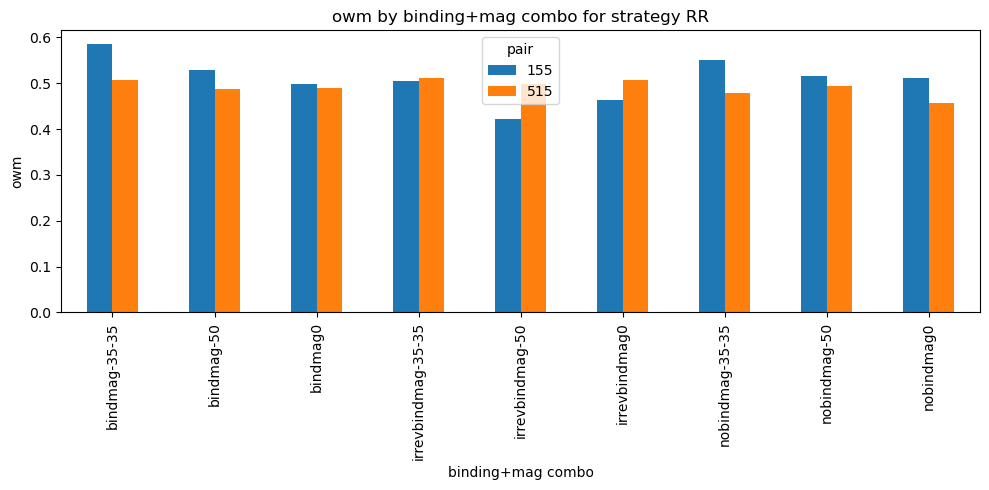

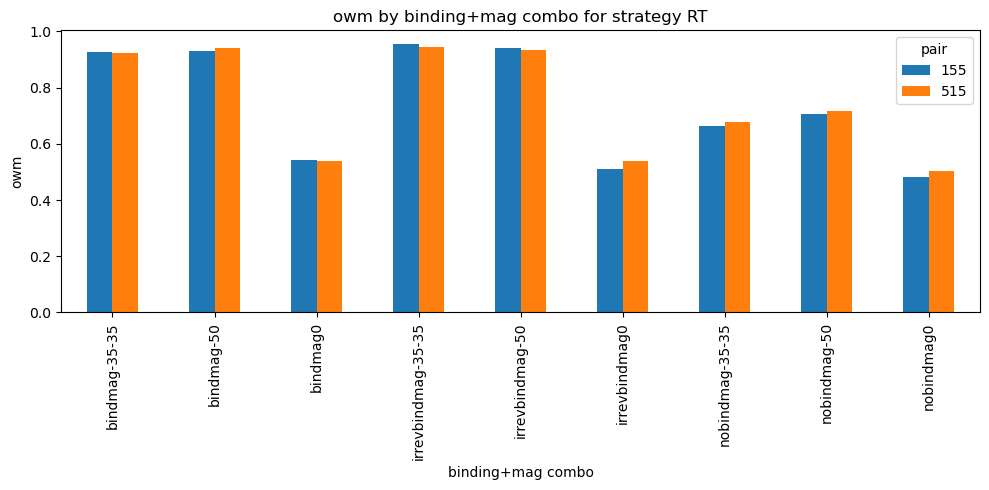

In [39]:
# Bar charts of ow_sps per strategy, grouped by binding+mag combo, with 155/515 side-by-side
import matplotlib.pyplot as plt

# Ensure required columns exist
req_cols = {'strategy','binding','mag','ow_sps'}
missing = [c for c in req_cols if c not in df_all.columns]
if missing:
	print(f"Missing columns in df_all; cannot plot: {missing}")
else:
	# Derive concentration pair token from filename if possible
	def detect_pair_from_row(r):
		name = str(r.get('filename',''))
		if '515' in name:
			return '515'
		if '155' in name:
			return '155'
		# Fallback: derive from C_sink_1/2 markers if present
		c1 = r.get('C_sink_1', None); c2 = r.get('C_sink_2', None)
		if c1 in (5,1) or c2 in (15,5):
			# heuristic
			if (c1, c2) == (5, 15):
				return '515'
			if (c1, c2) == (1, 5):
				return '155'
		return 'unknown'
	
	df_plot = df_all.copy()
	df_plot['pair'] = df_plot.apply(detect_pair_from_row, axis=1)
	# Build combination label like 'bindmag-50' or 'nobindmag0'
	df_plot['combo'] = df_plot.apply(lambda r: f"{r.get('binding','')}mag{r.get('mag','')}", axis=1)
	
	strategies = [s for s in sorted(df_plot['strategy'].dropna().unique())]
	pairs = ['155','515']
	
	for strat in strategies:
		df_s = df_plot[(df_plot['strategy'] == strat) & (df_plot['pair'].isin(pairs)) & (df_plot['combo'].notna())]
		if df_s.empty:
			print(f"No data for strategy {strat}")
			continue
		# average ow_sps over duplicates per (combo, pair)
		pt = df_s.pivot_table(index='combo', columns='pair', values='ow_sps', aggfunc='mean')
		# ensure columns order 155, 515
		pt = pt.reindex(columns=pairs)
		# sort combos alphabetically for stability
		pt = pt.sort_index()
		ax = pt.plot(kind='bar', figsize=(10,5))
		ax.set_title(f"owm by binding+mag combo for strategy {strat}")
		ax.set_ylabel('owm')
		ax.set_xlabel('binding+mag combo')
		ax.legend(title='pair')
		plt.tight_layout()
		plt.show()


In [22]:
RR = df_all[['filename','strategy','binding','mag','ow_sps','auc_total','w_max','t_peak_w']][df_all['strategy'] == 'RR']

In [23]:
RT = df_all[['filename','strategy','binding','mag','ow_sps','auc_total','w_max','t_peak_w']][df_all['strategy'] == 'RT']

In [24]:
RR['filename'] = (
    RR['filename']
    .str.replace(r'^n1000_t1000_pos_', '', regex=True)  # remove the prefix
    .str.replace(r'\.npy$', '', regex=True)             # remove the suffix
)

RT['filename'] = (
    RT['filename']
    .str.replace(r'^n1000_t1000_pos_', '', regex=True)  # remove the prefix
    .str.replace(r'\.npy$', '', regex=True)             # remove the suffix
)

In [27]:
RR['t_peak_w'] = RR['t_peak_w'].astype(int)
RT['t_peak_w'] = RT['t_peak_w'].astype(int)


RR['t_peak_w'] = RR['t_peak_w']*0.2
RT['t_peak_w'] = RT['t_peak_w']*0.2

In [1]:
print(RT.to_markdown(index=False))

NameError: name 'RT' is not defined

In [ ]:
print(RR.to_markdown(index=False))

| filename                   | strategy   | binding   | mag    |   ow_sps |   auc_total |   w_max |   t_peak_w |
|:---------------------------|:-----------|:----------|:-------|---------:|------------:|--------:|-----------:|
| RR_bind_155_mag-35-35      | RR         | bind      | -35-35 | 0.585927 |    1749.22  |   0.418 |      598.2 |
| RR_bind_155_mag-50         | RR         | bind      | -50    | 0.528364 |     979.346 |   0.213 |      575.2 |
| RR_bind_155_mag0           | RR         | bind      | 0      | 0.498401 |    2939.37  |   0.809 |      807.8 |
| RR_irrevbind_155_mag-35-35 | RR         | irrevbind | -35-35 | 0.5056   |    1561.6   |   0.368 |      813.2 |
| RR_irrevbind_155_mag-50    | RR         | irrevbind | -50    | 0.422643 |     915.758 |   0.201 |      399.2 |
| RR_irrevbind_155_mag0      | RR         | irrevbind | 0      | 0.464296 |    2698.15  |   0.753 |      796.4 |
| RR_nobind_155_mag-35-35    | RR         | nobind    | -35-35 | 0.550728 |    1748.26  |   0.41